In [88]:
import numpy as np
import pandas as pd
from copy import deepcopy

import matplotlib.pyplot as plt

In [89]:
def logistic(z):
    """ 
    Helper function
    Computes the logistic function 1/(1+e^{-x}) to each entry in input vector z.
    
    np.exp may come in handy
    Args:
        z: numpy array shape (d,) 
    Returns:
       logi: numpy array shape (d,) each entry transformed by the logistic function 
    """
    logi = 1.0 / ( 1.0 + np.exp(-z))
    assert logi.shape == z.shape
    return logi
    
def NaN_2_str(list):
    """
    Changing each np.nan in list to str(None)
    """
    transformed_list = []
    for object in list: transformed_list.append(str(object))
    return transformed_list

def col_2_matrix(col):
    """Helper function for One hot encoding of a column"""
    different_values = np.unique(col)
    matrix = np.zeros((len(col),len(different_values)))
    for row in range(len(col)):
        matrix[row][np.argwhere(col[row] == different_values)] = 1
    return matrix
    
def R2_coef(y_true,y_pred):
    """
    Calculates coefficient of determination 
    """
    u,v = 0,0
    for i in range(len(y_true)):
        u += (y_true[i] - y_pred[i])**2
        v += (y_true[i] - np.mean(y_true))**2
    return float(1 - u/v)

def remove_const_cols(training,validation):
    keep_indices = []
    for col in range(training.shape[1]):
        if not np.all(training[:,col][0]==training[:,col]):
            keep_indices.append(col)
    return training[:,keep_indices], validation[:,keep_indices] 

def normalize_data(vectors, labels):
    """ Normalizing s.t. each feature (column) has mean = 0 and then variance = 1 """
    # Labels
    Label_mean, Label_var = np.mean(labels), np.std(labels) 
    labels = labels - Label_mean     ## mean
    labels = labels * 1./Label_var   ## variance

    # Feature vectors
    for col in range(vectors.shape[1]):
        vectors[:,col] = vectors[:,col] - np.mean(vectors[:,col])    ## mean
        vectors[:,col] = vectors[:,col] * 1./np.std(vectors[:,col])  ## variance
    
    return (Label_mean, Label_var, vectors, labels)
    

In [90]:
class LogisticRegressionClassifier():

    def __init__(self,print_status = True):
        self.final_w = None
        self.print_status = print_status

        self.training_error_history   = None
        self.validation_error_history = None
        
        self.best_validation_error = None
        self.best_w = None


    def cost_grad(self, X, y, w, lmbda):
        """
        Compute the average negative log likelihood and gradient under the logistic regression model 
        using data X, targets y, weight vector w 
        
        np.log, np.sum, np.choose, np.dot may be useful here
        Args:
           X: np.array shape (n,d) float - Features 
           y: np.array shape (n,)  int - Labels 
           w: np.array shape (d,)  float - Initial parameter vector

        Returns:
           cost: scalar: the average negative log likelihood for logistic regression with data X, y 
           grad: np.arrray shape(d, ) gradient of the average negative log likelihood at w 
        """

        ########## If lamnda != 0 then using Weight decay (L2 Regularization) 


        cost = 0.0
        grad = np.zeros(w.shape)
        
        # Computing the cost #  
        for i in range(X.shape[0]):
            cost += np.log(1.0+np.exp(-(y[i]*np.dot(X[i],w))))
        cost *= 1.0/X.shape[0]

        # Computing the gradient vector #
        for i in range(X.shape[0]):
            grad += -y[i]*X[i]*logistic(-(y[i]*(np.dot(w,X[i]))))
        grad += lmbda * w @ w  # Weight decay (L2 Regularization) 
        grad *= 1.0/X.shape[0]

        assert grad.shape == w.shape
        return cost, grad


    def fit(self, X, y, X_valid, y_valid, w=None, lmbda = 0.1, lr=0.1, batch_size=32, epochs=50):
        """
        Run mini-batch stochastic Gradient Descent for logistic regression 
        use batch_size data points to compute gradient in each step.

        Args:
           X: np.array shape (n,d) dtype float32 - Features 
           y: np.array shape (n,) dtype int32 - Labels 
           w: np.array shape (d,) dtype float32 - Initial parameter vector
           lr: scalar - learning rate for gradient descent
           batch_size: number of elements to use in minibatch
           epochs: Number of scans through the data

        sets: 
           w: numpy array shape (d,) learned weight vector w
           history: list/np.array len epochs - value of cost function after every epoch. 
        """
        if w is None: w = np.zeros(X.shape[1])
        training_error_history = []     
        validation_error_history = []   
        self.best_validation_error= np.inf  # Initializing best validation error

        # Entering main loop #
        for j in range(epochs):   
            # Creating array of random integers from 0 - n in correct size#
            perm_array = np.random.permutation(X.shape[0])[:batch_size]
            # Picking out those random elements #
            x_batch, y_batch = X[perm_array], y[perm_array]
            # Gradient run #
            for i in range(X.shape[0]//batch_size):
                cost, grad = self.cost_grad(x_batch,y_batch,w,lmbda)
                w -= lr*grad

            # Calculating cost at current epoch #
            training_cost,_   = self.cost_grad(X,y,w,lmbda)
            validation_cost,_ = self.cost_grad(X_valid,y_valid,w,lmbda)

            # Appending value of cost function at current epoch #
            training_error_history.append(training_cost)
            validation_error_history.append(validation_cost)

            if validation_cost < self.best_validation_error:
                self.best_validation_error = validation_cost
                self.best_w                = deepcopy(w)

            if self.print_status: print(f'{j+1} out of {epochs} epochs done..')
        
        self.training_error_history   = training_error_history
        self.validation_error_history = validation_error_history
        # Setting current weights #
        self.final_w = w

    def predict(self, X, w=None):
        """ Classify each data element in X

        Args:
            X: np.array shape (n,d) dtype float - Features 
        
        Returns: 
           p: numpy array shape (n, ) dtype int32, class predictions on X (-1, 1)

        """
        out = logistic(X @ w)
        return out
    
    def score(self, X, y, w=None):
        """ Compute model accuracy  on Data X with labels y

        Args:
            X: np.array shape (n,d) dtype float - Features 
            y: np.array shape (n,) dtype int - Labels 

        Returns: 
           s: float, number of correct prediction divivded by n.

        """
        # Calculating predictions #
        prediction = self.predict(X,w)
        # Converting to {-1,1} #
        prediction = (np.round(prediction,0) * 2) - 1
        # Comparing to y and dividing by n #
        score = np.mean(prediction == y)
        return score

In [91]:
class Data:
    def __init__(self,filepath,label_col_idx, vector_col_range,encoder_type,split_data,validation_frac):
        assert type(filepath) is str, "filepath not given as string."
        assert encoder_type == "One hot" or encoder_type == "K vals", "Unknown encoder type"
        self.data_frame   = pd.read_csv(filepath)
        self.data_matrix = self.data_frame.values
    
        self.original_label_column_index  = label_col_idx
        self.original_vector_column_range = vector_col_range

        if self.original_vector_column_range[1] == -1: self.original_vector_column_range[1] = self.data_matrix.shape[1]
       
        self.labels  = self.data_matrix[:,self.original_label_column_index]
        self.vectors = self.data_matrix[:,[i for i in range(self.original_vector_column_range[0],self.original_vector_column_range[1])]]

        self.vectors[:,1] = self.name_title_search(self.vectors[:,1]) ## Special name title encoding (specific for this dataset)


        self.NaN_features_column_indices = self.initiate_NaN_features_column_indices()
        self.NaN_feature_dicts           = self.initiate_NaN_feature_dicts()
        self.encoded_vectors             = self.encode_vectors(encoder_type)

        self.validation_labels  = None
        self.validation_vectors = None
        self.training_labels    = None
        self.training_vectors   = None
        
        if split_data: self.split_data(validation_frac)

    def initiate_NaN_features_column_indices(self):
        NaN_features_column_indices = []
        for row in range(self.vectors.shape[0]):
            for col in range(self.vectors.shape[1]):
                if type(self.vectors[row][col]) is str:
                    if col not in NaN_features_column_indices:
                        NaN_features_column_indices.append(col)
        return np.sort(NaN_features_column_indices,kind='heapsort')
    
    def initiate_NaN_feature_dicts(self):
        NaN_feature_dicts = {}
        for feature_idx in self.NaN_features_column_indices:
            ith_feature_dict = {}
            for val_idx, kth_val in enumerate(np.unique(NaN_2_str(self.vectors[:,feature_idx]))):
                ith_feature_dict[str(kth_val)] = val_idx
            NaN_feature_dicts[str(feature_idx)] = ith_feature_dict
        return NaN_feature_dicts
    
    def encode_vectors(self, encoder_type):
        if encoder_type == "K vals":
            encoded_vectors = deepcopy(self.vectors)
            for feature_idx in self.NaN_features_column_indices:
                ith_feature_dict = self.NaN_feature_dicts[str(feature_idx)]
                for vector_idx in range(self.vectors.shape[0]):
                    new_val = ith_feature_dict[str(self.vectors[:,feature_idx][vector_idx])]
                    encoded_vectors[vector_idx][feature_idx] = new_val
            assert encoded_vectors.shape == self.vectors.shape
            return encoded_vectors
    
        if encoder_type == "One hot":
            init_mat = np.zeros((self.vectors.shape[0],1))
            for col in range(self.vectors.shape[1]):
                if col in self.NaN_features_column_indices:
                    one_hot_mat = col_2_matrix(self.vectors[:,col].astype(str))
                    init_mat = np.concatenate([init_mat,one_hot_mat],axis=1)
                else:
                    init_mat = np.concatenate([init_mat,self.vectors[:,col].reshape(self.vectors.shape[0],1)],axis=1)
            init_mat = init_mat[:,[i+1 for i in range(init_mat.shape[1]-1)]]
            return init_mat

    def name_title_search(self,name_list):
        encoded_list = []
        keywords = np.array(["Mr.","Miss.","Mrs.","Master.","Don.", "Dr.", "Rev.", "Major.", "Mme.", 
                            "Col.", "Capt.", "Countess.", "Ms.", "Lady.", "Sir.", "Mlle.", " Jonkheer."])

        for index, string in enumerate(name_list):
            current_string = string
            accumulated    = ''
            for idx in range(len(current_string)):
                current_substring = current_string[idx:-1]
                for letter in current_substring:
                    if accumulated in list(keywords):
                        title_index = np.argwhere(keywords == accumulated)[0][0]
                        encoded_list.append(title_index)
                        #print(accumulated,index,title_index,string)
                        break
                    accumulated += letter
                accumulated = ''
        return np.array(encoded_list)

    def split_data(self,validation_fraction):
        """ Setting "validation_fraction" % of data aside for validation (randomly chosen) """
        random_indices = np.random.choice([i for i in range(self.vectors.shape[0])],
                                            size=int(self.vectors.shape[0] * validation_fraction),replace=False)
        self.validation_vectors = self.encoded_vectors[random_indices]
        self.validation_labels  = self.labels[random_indices]

        remaining_indices  = np.array([i for i in range(self.vectors.shape[0]) if i not in random_indices])
        self.training_vectors   = self.encoded_vectors[remaining_indices]
        self.training_labels    = self.labels[remaining_indices] 
    




In [92]:
Filepath = "Data/train.csv"
original_label_column_index = 1
original_vector_column_range = [2,-1]

my_training_data = Data(Filepath,original_label_column_index,original_vector_column_range,"K vals",True,0.2)
training_vecs, training_labels     = my_training_data.training_vectors, my_training_data.training_labels
validation_vecs, validation_labels = my_training_data.validation_vectors, my_training_data.validation_labels


In [93]:
####### Special case for this data-set #######
counter = 0
ages = []
for age in (training_vecs[:,3]):
    if not np.isnan(age):
        ages.append(age)
    else:
        counter += 1
print(counter," Unknown ages replaced with mean in training data")
for i in range(training_vecs[:,3].shape[0]):
    if np.isnan(training_vecs[:,3][i]):
        training_vecs[:,3][i] = np.mean(ages)

counter = 0
ages = []
for age in (validation_vecs[:,3]):
    if not np.isnan(age):
        ages.append(age)
    else:
        counter += 1
print(counter," Unknown ages replaced with mean in validation data")
for i in range(validation_vecs[:,3].shape[0]):
    if np.isnan(validation_vecs[:,3][i]):
        validation_vecs[:,3][i] = np.mean(ages)
##############################################

140  Unknown ages replaced with mean in training data
37  Unknown ages replaced with mean in validation data


In [94]:
###### Setting binary to {-1,+1} instead of {0,+1} #######
for i in range(len(training_labels)):
    if training_labels[i] == 0:
        training_labels[i] = -1
for i in range(len(validation_labels)):
    if validation_labels[i] == 0:
        validation_labels[i] = -1

In [95]:
#### Removing constant features ####
training_vecs,validation_vecs = remove_const_cols(training_vecs,validation_vecs)

In [96]:
#### Normalizing 
Training_Label_mean, Training_Label_var, Training_vectors, Training_labels = normalize_data(training_vecs,training_labels)
Validation_Label_mean, Validation_Label_var, Validation_vectors, Validation_labels = normalize_data(validation_vecs,validation_labels)

Best validation error:  0.4013305259464345
Last validation error:  0.40729897613165084
Validation score: 0.8314606741573034


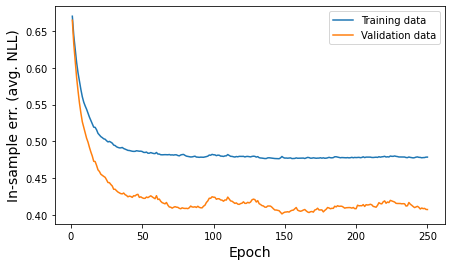

In [97]:
log_Reg = LogisticRegressionClassifier(print_status=False)
X, y = Training_vectors.astype(float),training_labels.astype(float)
X_valid, y_valid = Validation_vectors.astype(float),validation_labels.astype(float)
log_Reg.fit(X, y, X_valid, y_valid, lmbda = 0.0, lr=0.01, batch_size = 32, epochs=250)

fig, ax = plt.subplots(1,1,figsize=(7,4))
ax.set_xlabel("Epoch",size=14)
ax.set_ylabel("In-sample err. (avg. NLL)", size =14)
print("Best validation error: ", log_Reg.best_validation_error)
print("Last validation error: ", log_Reg.validation_error_history[-1])
ax.plot([i for i in range(1,len(log_Reg.training_error_history)+1)],log_Reg.training_error_history, label ="Training data")
ax.plot([i for i in range(1,len(log_Reg.validation_error_history)+1)],log_Reg.validation_error_history, label = "Validation data")
ax.legend()
print("Validation score:",log_Reg.score(X_valid,y_valid,log_Reg.best_w))
plt.show()

In [98]:
from sklearn.linear_model import LogisticRegression
# Create an instance of Logistic Regression Classifier and fit the data.
solvers   = ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
penalties = ["l2","l1","elasticnet"]
logreg = LogisticRegression(penalty=penalties[1],solver=solvers[4],l1_ratio=0.5)
logreg.fit(X,y)
logreg.score(X_valid,y_valid)

/Users/sebastianyde/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


0.8539325842696629